<a href="https://colab.research.google.com/github/Willlee0225/nbviewer/blob/master/%E5%88%A9%E7%94%A8%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99%E9%A0%90%E6%B8%AC%E6%BC%B2%E8%B7%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 利用技術分析指標來預測道瓊漲跌

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [4]:
from google.colab import files
uploaded = files.upload()

Saving DOW2.csv to DOW2.csv


In [0]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['DOW2.csv']))

## 從Yahool Finance 上面將道瓊的資料讀進來

In [6]:
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-06-07,1329.640015,1331.989990,1312.949951,1316.420044,1316.420044,8590000
1,1985-06-10,1314.290039,1322.579956,1307.239990,1318.439941,1318.439941,6120000
2,1985-06-11,1319.000000,1323.810059,1308.020020,1313.839966,1313.839966,8020000
3,1985-06-12,1312.050049,1318.209961,1300.739990,1306.339966,1306.339966,9550000
4,1985-06-13,1302.199951,1308.130005,1285.390015,1290.099976,1290.099976,13310000
...,...,...,...,...,...,...,...
8816,2020-06-01,25342.990234,25508.830078,25220.660156,25475.019531,25475.019531,338310000
8817,2020-06-02,25582.519531,25743.130859,25523.740234,25742.650391,25742.650391,352610000
8818,2020-06-03,25906.880859,26337.750000,25906.880859,26269.890625,26269.890625,398790000
8819,2020-06-04,26226.490234,26384.099609,26082.310547,26281.820313,26281.820313,372190000


In [0]:
data = df1[['Open', 'High', 'Low', 'Close', 'Volume']]

##  安裝TA-Lib

In [9]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2020-06-07 11:37:38--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-06-07 11:37:38--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-06-07 11:37:38--  https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving iweb.dl.sourceforge.ne

In [0]:
import talib

In [0]:
from talib import abstract

## 改成 TA-Lib 可以辨識的欄位名稱
## 這次利用MACD, RSI, MOM,STOCH來當作預測目標的因子 

In [0]:

data.columns = ['open','high','low','close','volume']

ta_list = ['MACD','RSI','MOM','STOCH']
# 快速計算與整理因子
for x in ta_list:
    output = eval('abstract.'+x+'(data)')
    output.name = x.lower() if type(output) == pd.core.series.Series else None
    data = pd.merge(data, pd.DataFrame(output), left_on = data.index, right_on = output.index)
    data = data.set_index('key_0')

In [13]:
data

,open,high,low,close,volume,macd,macdsignal,macdhist,rsi,mom,slowk,slowd
key_0,,,,,,,,,,,,
0,1329.640015,1331.989990,1312.949951,1316.420044,8590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1314.290039,1322.579956,1307.239990,1318.439941,6120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1319.000000,1323.810059,1308.020020,1313.839966,8020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1312.050049,1318.209961,1300.739990,1306.339966,9550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1302.199951,1308.130005,1285.390015,1290.099976,13310000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8816,25342.990234,25508.830078,25220.660156,25475.019531,338310000,468.578015,342.180888,126.397128,62.771517,1789.599609,73.617742,80.794716
8817,25582.519531,25743.130859,25523.740234,25742.650391,352610000,504.745971,374.693904,130.052067,64.932015,1145.281250,81.049996,79.293470
8818,25906.880859,26337.750000,25906.880859,26269.890625,398790000,569.389648,413.633053,155.756595,68.776335,2063.031250,87.867641,80.845127


## 目前進度整理：
### 標的：DOW （日資料）
### 預測目標：預測一週後（五交易日後）收盤價相對今日收盤價是漲或跌
###（New）資料數據：價量資料與 4 種技術指標

## 五日後漲標記 1，反之標記 0

In [0]:
data['week_trend'] = np.where(data.close.shift(-5) > data.close, 1, 0)

In [0]:
# 檢查資料有無缺值
data.isnull().sum()
# 最簡單的作法是把有缺值的資料整列拿掉
data = data.dropna()

In [0]:
# 決定切割比例為 70%:30%
split_point = int(len(data)*0.7)
# 切割成學習樣本以及測試樣本
train = data.iloc[:split_point,:].copy()
test = data.iloc[split_point:-5,:].copy()

In [0]:
# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X = train.drop('week_trend', axis = 1)
train_y = train.week_trend
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X = test.drop('week_trend', axis = 1)
test_y = test.week_trend

## 讓ＡＩ自己寫
### 安裝 sklearn

In [18]:
pip install -U scikit-learn


     |████████████████████████████████| 6.9MB 4.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 匯入決策樹分類器

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 7)

In [0]:
model.fit(train_X, train_y)
prediciton = model.predict(test_X)

### model 就是我們剛剛創造出來的決策樹，要讓它從過去資料學習的話，只要使用model.fit
###(train_X, train_y)即可。記得 train_X 是學習樣本的因子，而 train_y 是學習樣本的答案。

## 視覺化 A.I.決策樹

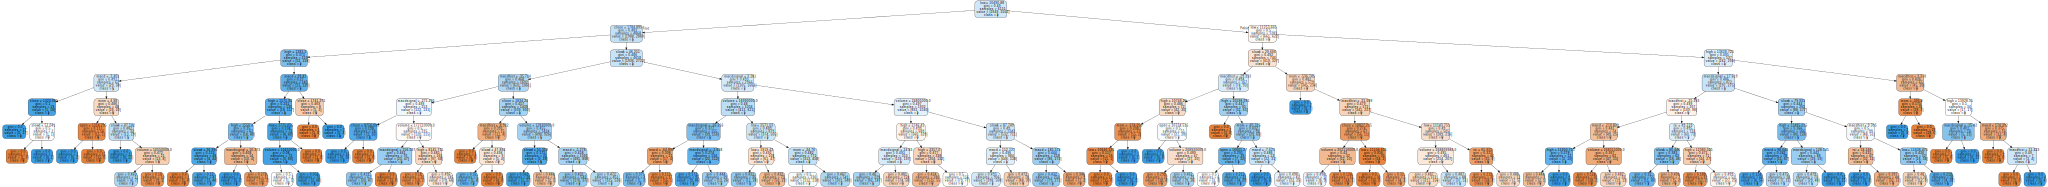

In [21]:
from sklearn.tree import export_graphviz
import graphviz 

dot_data = export_graphviz(model, out_file = None,
                           feature_names = train_X.columns,
                           filled = True, rounded = True,
                           class_names = True,
                           special_characters = True)
graph = graphviz.Source(dot_data)
graph

## 開始查看訓練成果
### 測驗結果分析

## 第一種：混淆矩陣

In [0]:
from sklearn.metrics import confusion_matrix



###（True跌）真實「跌」，而 A.I. 正確預測「跌」的次數一共 709 次
###（False漲）真實「跌」，但 A.I. 錯誤預測「漲」的次數一共 352 次
###（True漲）真實「漲」，而 A.I. 正確預測「漲」的次數一共 991次
###（False跌）真實「漲」，但 A.I. 錯誤預測「跌」的次數一共 580次

In [26]:
confusion_matrix(test_y, prediciton)

array([[709, 352],
       [991, 580]])

### 準確率 計算：（True跌 + True漲）/ 總樣本數

In [27]:
# 準確率
model.score(test_X, test_y)

0.489741641337386

## 第二種：ROC / AUC 分析

In [0]:
from sklearn.metrics import roc_curve, auc



In [0]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediciton)

### AUC = 1：表示這個 A.I. 是完美的
### 0.5 < AUC < 1：表示這個 A.I. 相比隨機猜測來得優秀，妥善運用的話，能夠產生預測價值
### AUC = 0.5：表示這個 A.I. 做的預測跟隨機猜測一樣，沒有價值
### AUC < 0.5：表示這個 A.I. 做的預測比隨機猜測還差；但是！如果把這個 A.I. 當成反指標，將每次的預測結果反過來，就會優於隨機猜測

In [32]:
# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)

0.5187145547449021

## 藍線為學習樣本，ＡＵＣ接近1
## 紅線為測試樣本，AUC在0.51徘徊


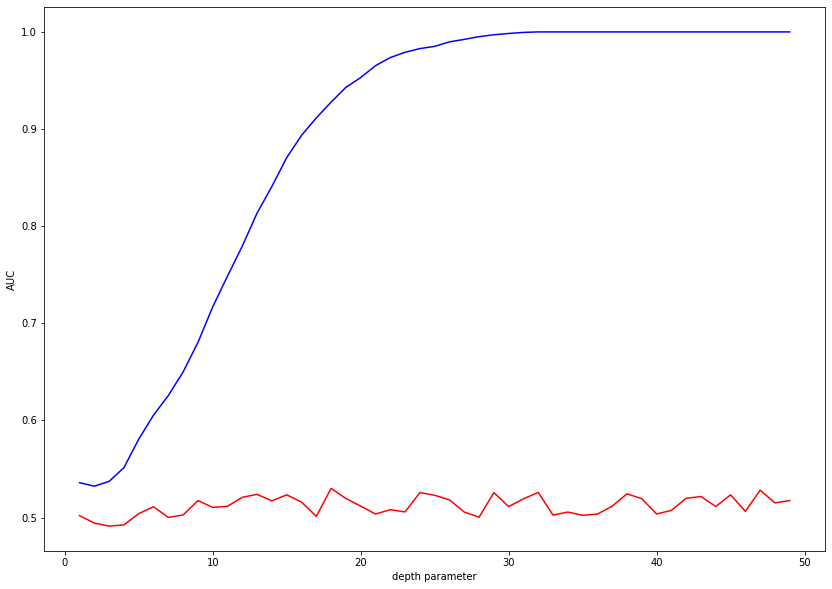

In [33]:
import matplotlib.pyplot as plt
depth_parameters = np.arange(1, 50)
# 準備兩個容器，一個裝所有參數下的訓練階段 AUC；另一個裝所有參數下的測試階段 AUC
train_auc= []
test_auc = []
for test_depth in depth_parameters:
    temp_model = DecisionTreeClassifier(max_depth = test_depth)
    temp_model.fit(train_X, train_y)
    train_predictions = temp_model.predict(train_X)
    test_predictions = temp_model.predict(test_X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, test_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    test_auc.append(auc_area)

# 繪圖視覺化
plt.figure(figsize = (14,10))
plt.plot(depth_parameters, train_auc, 'b', label = 'Train AUC')
plt.plot(depth_parameters, test_auc, 'r', label = 'Test AUC')
plt.ylabel('AUC')
plt.xlabel('depth parameter')
plt.show()


In [0]:
import pickle

# 儲存模型
filename = 'Decision_Tree_model_001.sav'
pickle.dump(model, open(filename, 'wb'))

# 取出模型
filename = 'Decision_Tree_model_001.sav'
model = pickle.load(open(filename, 'rb'))

In [58]:
model

DecisionTreeClassifier(max_depth=7)